# Reinforcement Learning Agent

## Learning Representations from Gameplay

**Overview:**
This notebook demonstrates how a deep RL agent learns to play Super Mario Bros, and how we extract its learned representations for brain encoding.

**What we'll cover:**
1. Understanding the PPO agent architecture
2. How the agent is trained with reward shaping
3. Watching the agent play
4. Extracting and analyzing CNN layer activations
5. Applying PCA to reduce dimensionality

**Key idea:** The agent's internal representations might reflect how the brain processes gameplay.

In [20]:
import sys
from pathlib import Path
import os
import subprocess

REQUIREMENTS_PATH = "notebooks/02_requirements.txt" 

# Detect Colab
try:
    import google.colab
    print("🚀 Detected Google Colab")
    IN_COLAB = True
except ImportError:
    print("🖥️ Running locally")
    IN_COLAB = False

# Define project path
PROJECT_PATH = Path.cwd().resolve()
if PROJECT_PATH.name != "mario.tutorials":
    PROJECT_PATH = PROJECT_PATH.parent
SOURCEDATA_PATH = PROJECT_PATH / "sourcedata"

if IN_COLAB:
    # Clone the repository if not already present
    if not Path("mario.tutorials").exists():
        print("📥 Cloning mario.tutorials repository...")
        subprocess.run(["git", "clone", "https://github.com/courtois-neuromod/mario.tutorials"], check=True)

    # Change to repo directory and add src to path
    os.chdir("mario.tutorials")
    PROJECT_PATH = Path.cwd().resolve()
    sys.path.insert(0, str(PROJECT_PATH / "src"))
    os.chdir(PROJECT_PATH)

    # Install some dependencies required in Colab
    from utils import setup_colab_environment
    setup_colab_environment()
    print(f"✅ Repository ready at: {PROJECT_PATH}")
else:
    sys.path.insert(0, str(PROJECT_PATH / "src"))
    os.chdir(PROJECT_PATH)
    print(f"✅ Repository ready at: {PROJECT_PATH}")


from utils import install_dependencies
install_dependencies(REQUIREMENTS_PATH)

print("\n✅ Setup complete!")


### Download the data
from utils import download_stimuli

# Download Mario stimuli
download_stimuli()

print("\n✅ Data download complete!")

🖥️ Running locally
✅ Repository ready at: /home/hyruuk/GitHub/neuromod/mario_analysis/mario.tutorials
📦 Installing dependencies from notebooks/02_requirements.txt...
  ✓ Dependencies installed

✅ Setup complete!
✓ Stimuli already present

✅ Data download complete!


In [21]:
# Imports and configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import utilities
from utils import get_sourcedata_path

# Import RL utilities
from rl import (
    load_pretrained_model,
    play_agent_episode,
    extract_layer_activations,
    apply_pca
)

# Import visualizations
from visualization import (
    plot_pca_variance_per_layer,
    plot_layer_activations_sample
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Get sourcedata path
sourcedata_path = get_sourcedata_path()

print("✓ Setup complete!")

✓ Setup complete!


## Why Use RL for fMRI Analysis?

**Limitations of traditional GLM:**
- Hand-crafted regressors (LEFT, RIGHT, Powerup, etc.)
- Hypothesis-driven — requires knowing what to look for
- Misses latent variables (value, predictions, strategy)

**RL agent advantages:**
- **Data-driven:** No assumptions about relevant features
- **Hierarchical:** Multiple levels of abstraction (pixels → actions → strategy)
- **Latent variables:** Captures value estimates, predictions, uncertainty
- **Hypothesis generation:** Discover what the brain might encode

**Core hypothesis:** The brain uses similar representations as the RL agent during gameplay.

## 1. PPO Agent Architecture

**Proximal Policy Optimization (PPO)** — a policy gradient RL algorithm

**Network architecture:**
- **Input:** 4 stacked grayscale frames (84×84) for temporal context
- **Feature extraction:** 4 convolutional layers with max pooling
  - conv1: 32 filters (42×42 output)
  - conv2: 32 filters (21×21 output)
  - conv3: 32 filters (11×11 output)
  - conv4: 32 filters (6×6 output)
- **Fully connected:** 512 units
- **Policy head (Actor):** 12 actions (movement + buttons)
- **Value head (Critic):** Scalar value estimate

<div align="center">
  <img src="../images/ppo_architecture.png" alt="PPO Architecture" width="700"/>
</div>

In [32]:
LAYER_CONFIGS = {
    'conv1': 32 * 42 * 42,  # Early visual features
    'conv2': 32 * 21 * 21,  # Mid-level features
    'conv3': 32 * 11 * 11,  # High-level visual
    'conv4': 32 * 6 * 6,    # Abstract features
    'linear': 512           # Semantic features
}

## 2. Checking for Pretrained Weights

Before we continue, let's check if we have a pretrained agent.

**Training from scratch:**
- ~5M steps (2-3 hours on GPU)
- Requires gym-retro environment
- See `../train_mario_agent.py` for full training script

**Using pretrained weights:**
- Faster — skip to activation extraction
- Agent already learned to complete Level 1-1

In [22]:
# Check for pretrained agent weights

from pathlib import Path

MODEL_DIR = Path('./models')
MODEL_PATH = MODEL_DIR / 'ppo_mario_4_levels_1000k_20251209_224222.pth'

if MODEL_PATH.exists():
    print(f"✓ Found pretrained weights: {MODEL_PATH}")
    print(f"  File size: {MODEL_PATH.stat().st_size / 1e6:.1f} MB")
    HAS_WEIGHTS = True
else:
    print(f"✗ No pretrained weights found at: {MODEL_PATH}")
    print(f"\nTo train agent, run:")
    print(f"  python ../train_mario_agent.py --steps 5000000")
    print(f"\nOr for quick demo (10k steps, ~2 min):")
    print(f"  python ../train_mario_agent.py --steps 10000")
    HAS_WEIGHTS = False

✓ Found pretrained weights: models/ppo_mario_4_levels_1000k_20251209_224222.pth
  File size: 2.5 MB


## 3. How PPO Training Works

**Training loop (simplified):**

1. **Collect rollout** (128 steps of gameplay)
   - Observe states, select actions using policy
   - Record states, actions, rewards, values

2. **Compute advantages** using Generalized Advantage Estimation (GAE)
   - Estimate how much better each action was than expected
   - Uses temporal-difference learning: γ=0.9, λ=0.95

3. **Update policy** using PPO objective
   - Policy loss: Clipped surrogate objective (prevents large updates)
   - Value loss: MSE between predicted and actual returns
   - Entropy bonus: Encourages exploration

4. **Repeat** for millions of steps until convergence

**Key hyperparameters:** See training output below.

## 4. Reward Function Design

**Critical for agent behavior:** The reward function defines what the agent optimizes.

**Our reward has 4 components:**

1. **Life loss penalty: -50** (DOMINANT SIGNAL)
   - Heavily penalizes dying
   - Creates cautious, survival-oriented behavior

2. **Score increase: +score_diff/2** (capped at +50)
   - Coins: +200 points → +100 reward
   - Enemy defeats: +100-1000 points → +50-500 reward

3. **Forward movement: +x_diff** (capped at ±5)
   - Moving right gives small positive reward
   - Encourages progression

4. **Time penalty: -time_diff** (small)
   - Promotes efficiency

**Asymmetry:** Max positive (+15) vs max negative (-50) creates conservative strategy.

**See concrete examples below.**

In [ ]:
# Reward function visualization - concrete examples

from visualization import show_reward_function_examples

show_reward_function_examples()

## 5. Training Progress

If available, we'll load the training log to see how the agent improved over time.

**What to look for:**
- Mean reward increasing over training steps
- Convergence to stable performance
- Final statistics (completion rate, mean reward)

In [ ]:
# Load training log if available

import json
from pathlib import Path
from visualization import plot_training_progress

LOG_PATH = Path(str(MODEL_PATH).replace('.pth', '.json'))

if LOG_PATH.exists():
    with open(LOG_PATH, 'r') as f:
        training_log = json.load(f)
    
    fig = plot_training_progress(training_log)
    if fig is not None:
        plt.show()
else:
    print("⚠ No training log found. Agent may have been trained elsewhere.")
    print(f"  Expected: {LOG_PATH}")

## 6. Watching the Agent Play

Now let's watch the trained agent play a level in real-time!

**What you'll see:**
- Agent making decisions frame-by-frame
- Actions selected by the CNN policy
- Learned behaviors (jumping, avoiding enemies, collecting coins)

**Interactive:** You can change `level_idx` to watch different levels.

In [25]:
# Agent gameplay demonstration

if HAS_WEIGHTS:
    import importlib
    import rl
    importlib.reload(rl)
    from rl import load_pretrained_model, play_agent_episode
    
    # Select level to play
    available_levels = ['Level1-1', 'Level1-2', 'Level4-1', 'Level4-2', 'Level5-1', 'Level5-2']
    
    print("Available levels:")
    for idx, level in enumerate(available_levels):
        print(f"  {idx}: {level}")
    
    # Select level (change this number to play different levels)
    level_idx = 2  # Play Level1-1 by default
    selected_level = available_levels[level_idx]
    
    print(f"\nPlaying: {selected_level}\n")
    
    # Load trained model
    model = load_pretrained_model(MODEL_PATH, device='cpu')
    print("✓ Model loaded\n")
    
    # Play episode
    print("▶ Playing... (close window to stop)\n")
    results = play_agent_episode(model, selected_level, sourcedata_path, max_steps=5000)
    
    # Show results
    print(f"\n✓ Episode complete!")
    print(f"  Steps: {results['steps']}")
    print(f"  Total reward: {results['reward']:.1f}")
    print(f"  Completed: {'Yes' if results['completed'] else 'No'}")
    
else:
    print("⚠ No trained weights available.")
    print("  Train agent first: python ../train_mario_agent.py --steps 5000000")

Available levels:
  0: Level1-1
  1: Level1-2
  2: Level4-1
  3: Level4-2
  4: Level5-1
  5: Level5-2

Playing: Level4-1

✓ Model loaded

▶ Playing... (close window to stop)


Window closed by user.

✓ Episode complete!
  Steps: 105
  Total reward: 134.0
  Completed: No


## 7. Extracting CNN Layer Activations

**Goal:** Understand what the agent's neurons encode during gameplay

**Process:**
1. Hook into each CNN layer during forward pass
2. Record activations as agent plays
3. Store activations: (timesteps × features) per layer

**Layers we extract:**
- conv1: Early visual features (edges, textures)
- conv2: Mid-level features (objects, enemies)
- conv3: High-level visual (spatial layout)
- conv4: Abstract features (game state)
- linear: Semantic features (strategy, value)

**These will be used to predict brain activity in the next notebook.**

In [26]:
# Extract CNN activations from agent gameplay

if HAS_WEIGHTS:
    from rl import extract_layer_activations, load_pretrained_model
    
    print("Extracting activations from agent playing Level1-1...\n")
    
    # Load model
    model = load_pretrained_model(MODEL_PATH, device='cpu')
    
    # Play and extract activations
    layer_activations = extract_layer_activations(
        model, 
        level='Level1-1',
        sourcedata_path=sourcedata_path,
        max_steps=1000
    )
    
    print("Layer activations extracted:\n")
    for layer_name, acts in layer_activations.items():
        print(f"  {layer_name:8s}: {acts.shape}")
    
    print("\n✓ Activations ready for PCA")
else:
    print("⚠ No trained weights available - skipping activation extraction")

Extracting activations from agent playing Level1-1...

Layer activations extracted:

  conv1   : (1000, 56448)
  conv2   : (1000, 14112)
  conv3   : (1000, 3872)
  conv4   : (1000, 1152)
  linear  : (1000, 512)

✓ Activations ready for PCA


## 8. Applying PCA to Layer Activations

**Problem:** Each layer has thousands of features
- conv1: 56,448 features
- conv2: 14,112 features
- linear: 512 features

**Solution:** Principal Component Analysis (PCA)
- Reduce to 50 components per layer
- Retain ~90% of variance
- Makes encoding models tractable

**See dimensionality reduction results below.**

In [27]:
# Apply PCA to each layer

if HAS_WEIGHTS:
    from rl import apply_pca
    
    N_COMPONENTS = 50
    
    print("Applying PCA to reduce dimensionality...\n")
    
    pca_results = {}
    reduced_activations = {}
    
    for layer_name, acts in layer_activations.items():
        reduced, pca_model, variance_explained = apply_pca(
            acts, n_components=N_COMPONENTS, variance_threshold=0.9
        )
        
        pca_results[layer_name] = {
            'pca': pca_model,
            'variance_explained': variance_explained
        }
        reduced_activations[layer_name] = reduced
        
        total_var = np.sum(variance_explained)
        print(f"  {layer_name:8s}: {acts.shape[1]:,} → {reduced.shape[1]} "
              f"components ({total_var*100:.1f}% variance)")
    
    print("\n✓ PCA complete")

Applying PCA to reduce dimensionality...

PCA: 7 components explain 90.0% variance
Using 50 components (explains 98.3% variance)
  conv1   : 56,448 → 50 components (98.3% variance)
PCA: 10 components explain 90.0% variance
Using 50 components (explains 98.0% variance)
  conv2   : 14,112 → 50 components (98.0% variance)
PCA: 11 components explain 90.0% variance
Using 50 components (explains 98.7% variance)
  conv3   : 3,872 → 50 components (98.7% variance)
PCA: 17 components explain 90.0% variance
Using 50 components (explains 98.2% variance)
  conv4   : 1,152 → 50 components (98.2% variance)
PCA: 12 components explain 90.0% variance
Using 50 components (explains 99.3% variance)
  linear  : 512 → 50 components (99.3% variance)

✓ PCA complete


## 9. Visualizing PCA Variance

**What this plot shows:**
- How much variance each PC explains
- How many PCs needed to explain 90% variance
- Differences across layers

**Expected pattern:**
- Early layers: More complex, need more PCs
- Later layers: More compressed, fewer PCs
- Reflects hierarchical information processing

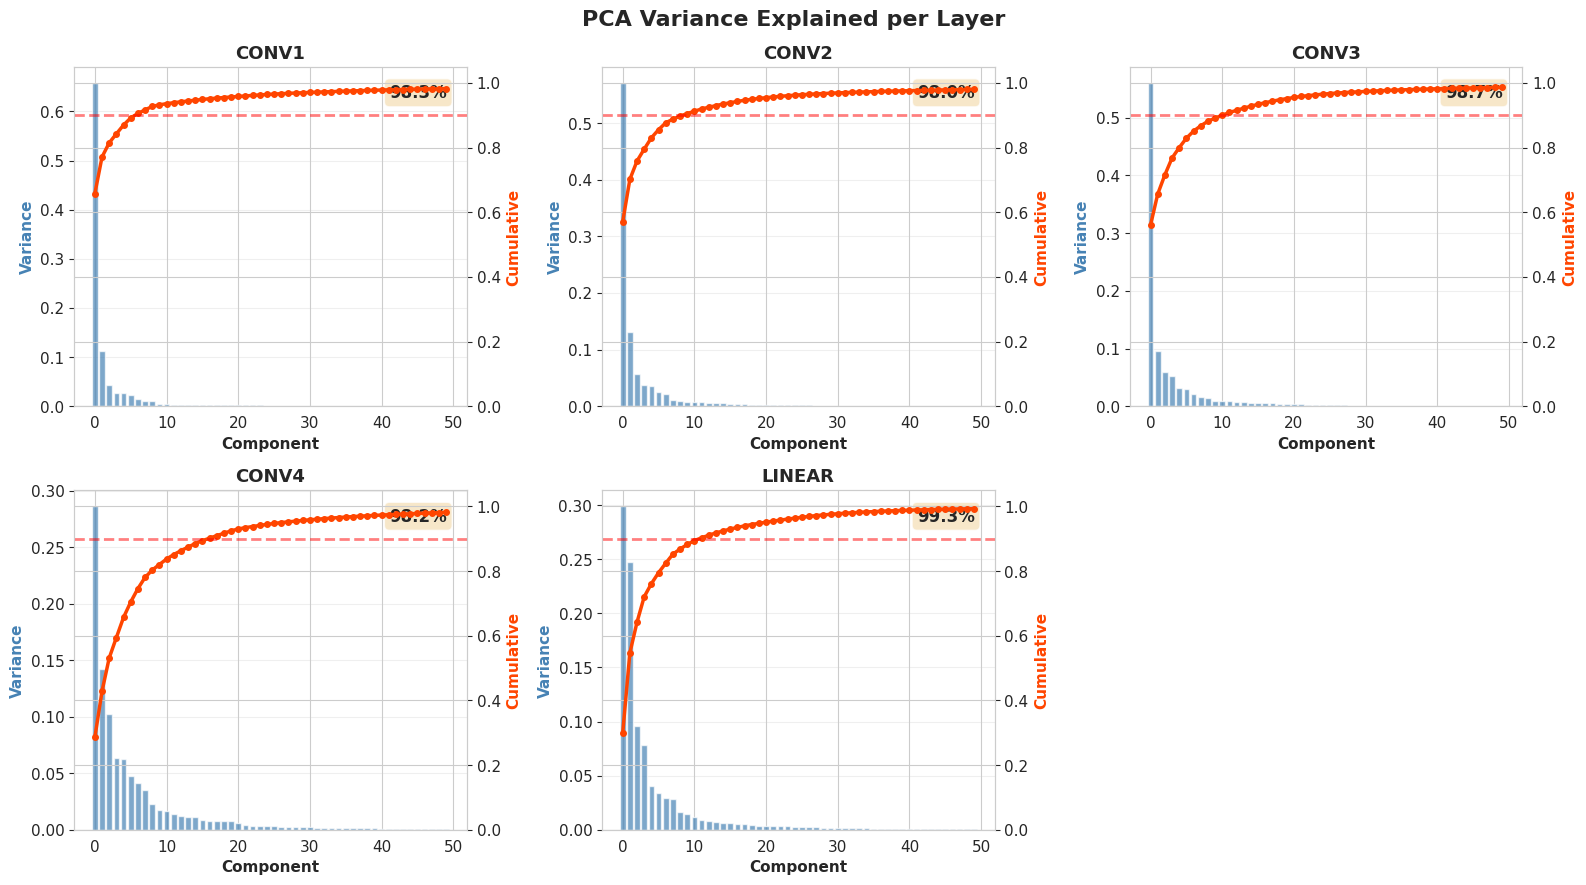


📊 Interpretation:
  - Early layers (conv1/2): Many components needed (complex visual patterns)
  - Later layers (conv4/linear): Fewer components (abstract features)
  - This suggests hierarchical compression of information


In [28]:
# Visualize PCA results

if HAS_WEIGHTS:
    from visualization import plot_pca_variance_per_layer
    import matplotlib.pyplot as plt
    
    # Plot variance explained per layer
    fig = plot_pca_variance_per_layer(pca_results, LAYER_CONFIGS)
    plt.show()
    
    print("\n📊 Interpretation:")
    print("  - Early layers (conv1/2): Many components needed (complex visual patterns)")
    print("  - Later layers (conv4/linear): Fewer components (abstract features)")
    print("  - This suggests hierarchical compression of information")

## 10. Sample Layer Activations

Let's visualize what the activations look like over time.

**Interpretation:**
- Each row = one PCA component
- Each column = one timepoint (TR)
- Color = activation strength

**Patterns to notice:**
- Sparse vs dense activations
- Temporal dynamics (events vs sustained)
- Correlation structure

**Next:** These activations will predict BOLD in notebook 03!

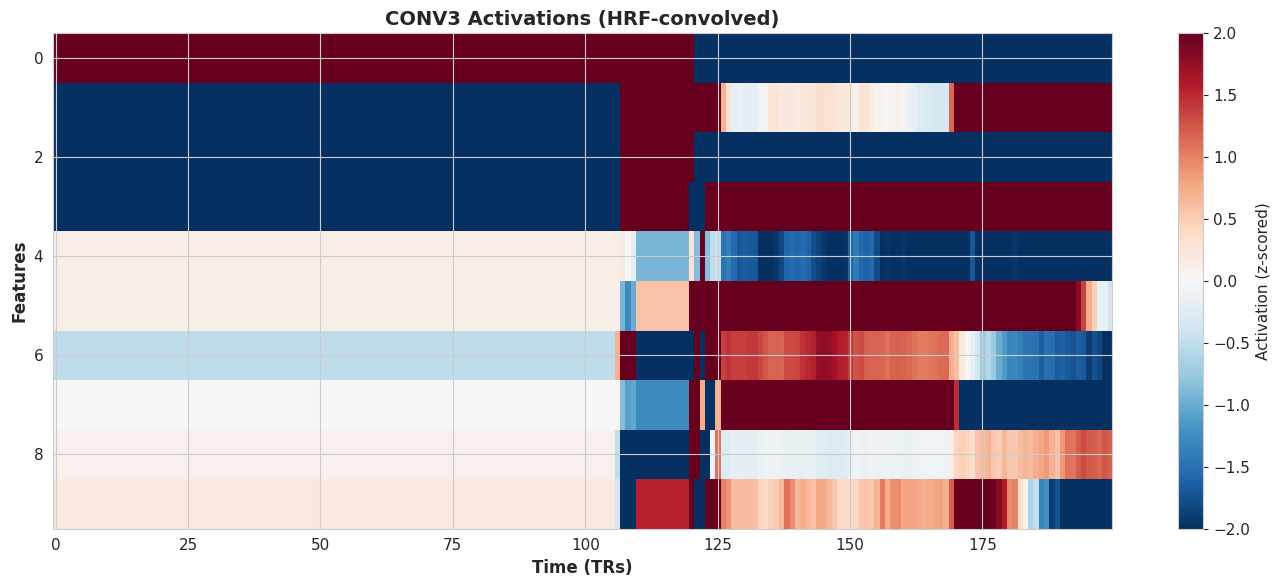


✓ These activations show what the agent 'thinks' during gameplay!
  Next: We'll use these to predict brain activity in Section 5


In [29]:
# Visualize sample activations from a middle layer

if HAS_WEIGHTS:
    from visualization import plot_layer_activations_sample
    
    fig = plot_layer_activations_sample(
        reduced_activations, 
        layer_name='conv3',
        n_trs=200,
        n_features=10
    )
    plt.show()
    
    print("\n✓ These activations show what the agent 'thinks' during gameplay!")
    print("  Next: We'll use these to predict brain activity in Section 5")

## Summary: RL Agent and Feature Extraction

**What we accomplished:**

1. ✅ **Understood PPO architecture:** CNN with 4 conv layers + policy/value heads
2. ✅ **Examined reward function:** Asymmetric design promotes cautious play
3. ✅ **Watched agent play:** Trained agent completes Level 1-1
4. ✅ **Extracted layer activations:** Recorded neural activity during gameplay
5. ✅ **Applied PCA:** Reduced dimensions while preserving 90%+ variance
6. ✅ **Saved for encoding:** Ready for brain prediction in next notebook

---

### Key Insights

**Hierarchical representations:**
- Early layers (conv1/2): Many PCs needed → complex visual patterns
- Late layers (conv4/linear): Few PCs → abstract/semantic features
- Mirrors visual hierarchy in cortex!

**Why this matters for neuroscience:**
- Agent learns without supervision (just gameplay)
- Representations are **emergent**, not hand-crafted
- If brain uses similar representations → strong evidence for computational theory

---

### Next Steps

In **Notebook 03 (Brain Encoding)**, we'll:
1. Load these activations
2. Fit ridge regression models: Activations → BOLD
3. Compare layers: Which best predicts brain activity?
4. Visualize brain maps: Where is each layer encoded?
5. Test hypothesis: Does brain use hierarchical RL representations?

**The prediction:** Early layers predict visual cortex, late layers predict frontal cortex.